## Forecasting usando RNN
El objetivo de este pequeño proyecto es realizar un forecast corrigiendo los realizados por Prophet de meta, ya que este puede tener algunos cesgos y crear nuestro propio modelo nos puede proporcionar mayor control sobre lo que se puede y debe de hacer. Para este caso crearemos un modelo desde cero y compararemos contra su semejante de Prophet.

### 1.1 Cargamos las librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
import os
from dotenv import load_dotenv

/Users/erickavendanogarcia/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
### 1.0 Fijar semilla para reproducibilidad
import tensorflow as tf
import random

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Configurar tensorflow para reproducibilidad estricta (opcional)
# Esto puede hacer que el entrenamiento sea un poco más lento
tf.config.experimental.enable_op_determinism()


### 1.2 Cargamos los datos necesarios

In [3]:
load_dotenv(dotenv_path=".env", override=True)
df_prueba = pd.read_csv(os.getenv("csv_ruta"))
df_prueba

,ds,y
0,2024-01-01,3467585
1,2024-02-01,765733
2,2024-03-01,3260182
3,2024-04-01,489422
4,2024-05-01,280569
5,2024-06-01,120035
6,2024-07-01,117860
7,2024-08-01,87600
8,2024-09-01,82089
9,2024-10-01,15373807


### 1.3 Normalizamos los datos

In [4]:
# Normalizar la columna "y"
scaler = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler.fit_transform(df_prueba[["y"]])

### 1.4 Creación, entrenamiento y predicción del modelo

In [5]:

# Crear secuencias para RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 4
X, y = create_sequences(y_scaled, seq_length)

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False
)

# Construir modelo RNN
model = keras.models.Sequential([
    keras.layers.SimpleRNN(30, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(30,activation="relu"),
    keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/Users/erickavendanogarcia/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, None, 30)       │           960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,821 (11.02 KB)

 Trainable params: 2,821 (11.02 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Entrenar modelo

history = model.fit(X_train, y_train, epochs=10, batch_size=14, validation_data=(X_test, y_test))

# Predecir los siguientes 6 pasos
# ---------------------------
last_sequence = X_test[-1:]  # última secuencia del conjunto de prueba
preds = []

for _ in range(6):
    pred = model.predict(last_sequence, verbose=0)
    preds.append(pred[0,0])
    # Convertir pred a 3D y concatenar a la secuencia para siguiente predicción
    pred_3d = pred.reshape((1,1,1))
    last_sequence = np.concatenate([last_sequence[:,1:,:], pred_3d], axis=1)

# Desnormalizar predicciones
preds_rescaled = scaler.inverse_transform(np.array(preds).reshape(-1,1))

Epoch 1/10


2025-08-17 00:10:38.128797: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-08-17 00:10:38.129205: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step - loss: 0.1339 - val_loss: 0.3088
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1219 - val_loss: 0.2743
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1101 - val_loss: 0.2416
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0996 - val_loss: 0.2114
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0908 - val_loss: 0.1825
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0837 - val_loss: 0.1562
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0780 - val_loss: 0.1352
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0739 - val_loss: 0.1185
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0712 - val_loss: 0.1065
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0697 - val_loss: 0.0987


In [7]:
preds_rescaled

array([[12274620. ],
       [14626872. ],
       [ 6196130.5],
       [ 9967864. ],
       [ 9055163. ],
       [ 4157937. ]], dtype=float32)

### 1.5 Grafica de resultados

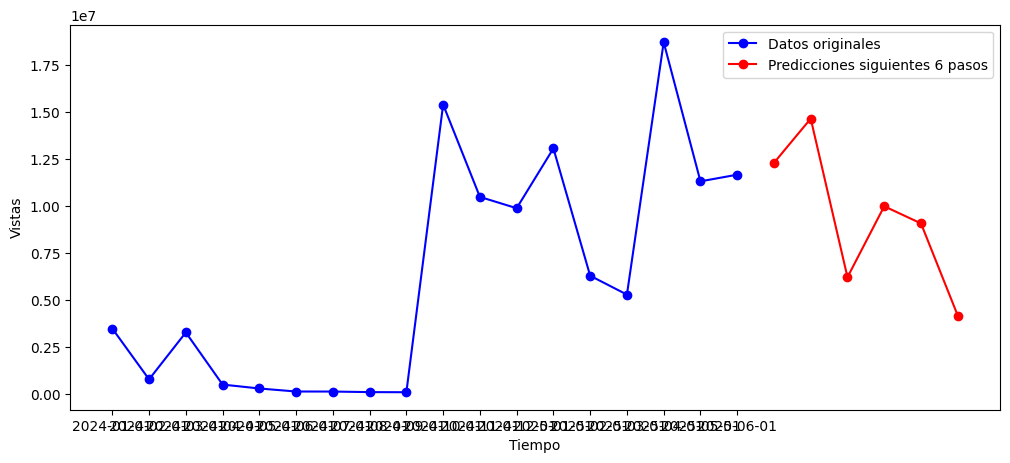

In [8]:
plt.figure(figsize=(12,5))
plt.plot(df_prueba["ds"], df_prueba["y"],'bo-', label="Datos originales")
plt.plot(range(len(df_prueba), len(df_prueba)+6), preds_rescaled, 'ro-', label="Predicciones siguientes 6 pasos")
plt.xlabel("Tiempo")
plt.ylabel("Vistas")
plt.legend()
plt.show()

### 1.6 Validación del Modelo

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np

y_true = y_test  # reales
y_pred = model.predict(X_test).flatten()  # predicciones

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
MSE: 0.0987
MAE: 0.2279
MAPE: 37.43%


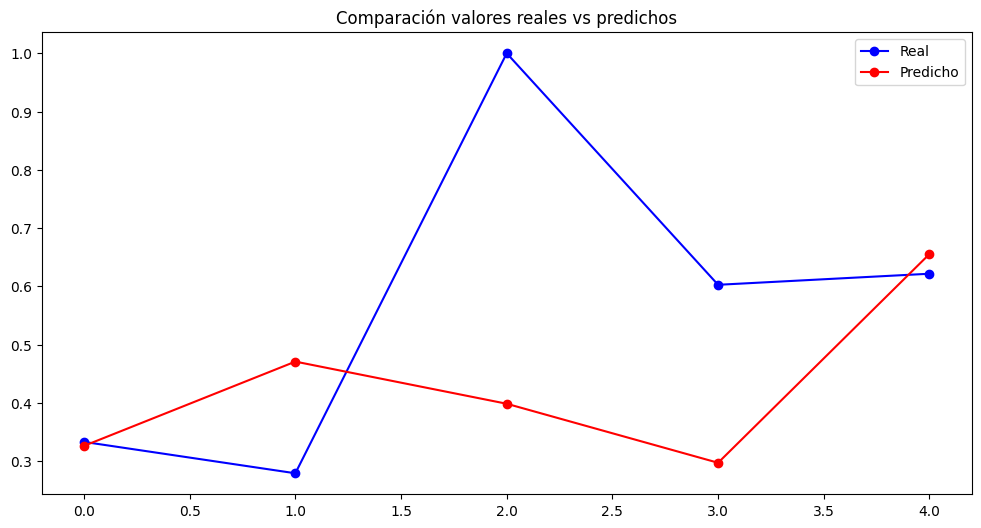

In [10]:
plt.figure(figsize=(12,6))
plt.plot(y_true,'bo-', label="Real")
plt.plot(y_pred,'ro-', label="Predicho")
plt.legend()
plt.title("Comparación valores reales vs predichos")
plt.show()
